# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries

In [1]:
# Install requred libraries

# Import Libraries

In [11]:
#Load the required libraries

import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import joblib

import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Dropout, Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler


import warnings
warnings.filterwarnings("ignore")


# Import Data

In [3]:
bitcoin_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/01 Projects/Cryptocurrencies/Data/binance/BTCUSDT_final_clean.csv")

In [4]:
bitcoin_df.head()

,date,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,3.675857e+06,7640.0,226.153126,1.624289e+06
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,6.365953e+06,9033.0,570.721419,4.114804e+06
2,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,4.736719e+06,7466.0,357.180263,2.582514e+06
3,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,5.667367e+06,8337.0,394.810811,2.854987e+06
4,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,3.379094e+06,5896.0,243.514706,1.759053e+06


Here's a breakdown of each feature:

- **date**: This represents the opening time of a specific period in Unix time format. Unix time is a way to represent time as the number of seconds that have elapsed since January 1, 1970.

- **open**: This refers to the opening price of the trading instrument at the given period.

- **high**: This represents the highest price reached by the trading instrument during the specified period.

- **low**: This denotes the lowest price reached by the trading instrument during the specified period.

- **close**: This indicates the closing price of the trading instrument at the given period.

- **volume**: This refers to the total volume, typically the quantity of the trading instrument, traded during the specified period.


- **quote_volume**: This refers to the total volume in terms of the quote asset. The quote asset is the asset used to determine the value of the trading instrument.

- **count**: This represents the number of trades that occurred during the specified period.

- **taker_buy_volume**: This denotes the volume of the quote asset bought by takers (market takers) during the specified period.

- **taker_buy_quote_volume**: This represents the volume of the base asset bought by takers (market takers) during the specified period.

In [5]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29928 entries, 0 to 29927
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    29928 non-null  object 
 1   open                    29928 non-null  float64
 2   high                    29928 non-null  float64
 3   low                     29928 non-null  float64
 4   close                   29928 non-null  float64
 5   volume                  29928 non-null  float64
 6   quote_volume            29928 non-null  float64
 7   count                   29928 non-null  float64
 8   taker_buy_volume        29928 non-null  float64
 9   taker_buy_quote_volume  29928 non-null  float64
dtypes: float64(9), object(1)
memory usage: 2.3+ MB


# Datetime Conversion

In [6]:
# Converting the Date column from object to datetime
bitcoin_df[["date"]] = bitcoin_df[["date"]].apply(pd.to_datetime)

In [7]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29928 entries, 0 to 29927
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    29928 non-null  datetime64[ns]
 1   open                    29928 non-null  float64       
 2   high                    29928 non-null  float64       
 3   low                     29928 non-null  float64       
 4   close                   29928 non-null  float64       
 5   volume                  29928 non-null  float64       
 6   quote_volume            29928 non-null  float64       
 7   count                   29928 non-null  float64       
 8   taker_buy_volume        29928 non-null  float64       
 9   taker_buy_quote_volume  29928 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 2.3 MB


# Modeling

In [8]:
bitcoin_df = bitcoin_df.drop(columns=["count", "quote_volume", "taker_buy_volume", "taker_buy_quote_volume"])
bitcoin_df

,date,open,high,low,close,volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603
2,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809
3,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867
4,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578
...,...,...,...,...,...,...
29923,2023-05-31 19:00:00,27037.06,27123.43,27000.20,27010.57,1064.241890
29924,2023-05-31 20:00:00,27010.57,27116.13,27005.16,27114.20,835.439160
29925,2023-05-31 21:00:00,27114.19,27119.77,27045.61,27090.79,644.019020
29926,2023-05-31 22:00:00,27090.78,27193.24,27084.92,27183.98,999.118680


In [9]:
bitcoin_df.shape

(29928, 6)

### Preprocessing

In [30]:
# Scaling

scaler = MinMaxScaler()

scaled_close = scaler.fit_transform(bitcoin_df['close'].values.reshape(-1, 1))


# Creating Sequences and 3-D as requered for LSTM

seq_len = 100

def create_sequences(data, seq_len):
    sequences = []

    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])

    return np.array(sequences)

def preprocess_data(data_raw, seq_len, train_split):
    sequences = create_sequences(data_raw, seq_len)

    num_train = int(train_split * sequences.shape[0])

    X_train = sequences[:num_train, :-1, :]
    y_train = sequences[:num_train, -1, :]

    X_test = sequences[num_train:, :-1, :]
    y_test = sequences[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess_data(scaled_close, seq_len, train_split=0.8)


In [14]:
X_train.shape

(23862, 99, 1)

In [15]:
X_test.shape

(5966, 99, 1)

### Training

In [ ]:
# Modeling

window = seq_len - 1

model=Sequential()

model.add(GRU(50,return_sequences=True,input_shape=(window, X_train.shape[-1])))
model.add(Dropout(0.20))

model.add(GRU(50,return_sequences=True))

model.add(GRU(50))

model.add(Dense(1))


model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)


# Callbacks

checkpoint_path = 'LSTM_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping, lr_schedule]


# Fitting

batches = 128

history = model.fit(
                    X_train,
                    y_train,
                    epochs = 100,
                    batch_size = batches,
                    shuffle = True,
                    validation_split = 0.2,
                    callbacks = callbacks
                )


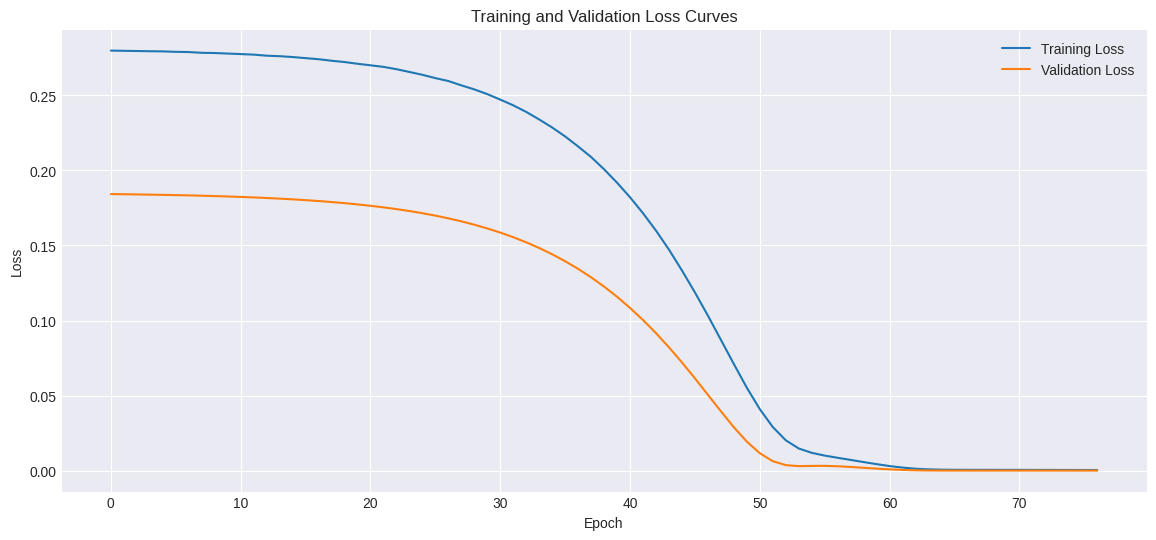

In [21]:
# Train/Val Curves

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')

ax.set_title('Training and Validation Loss Curves')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend(loc='upper right')

plt.show()

### Prediction

In [23]:
# Prediction

y_pred = model.predict(X_test)

187/187 [==============================] - 11s 61ms/step


In [24]:
# Rescaling

y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

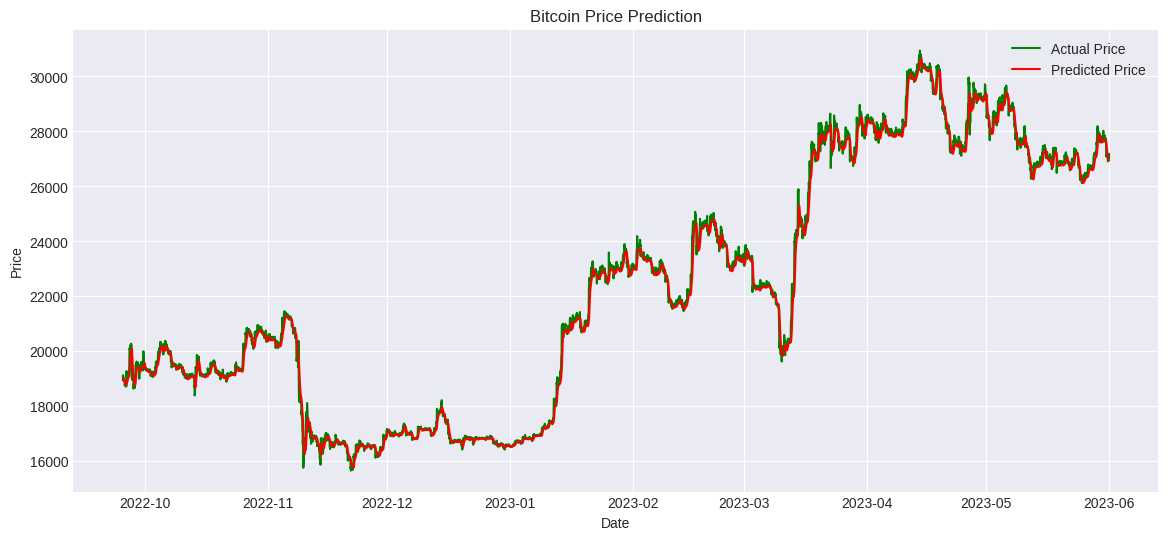

In [26]:
# Plotting Actual vs. Predicted

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(bitcoin_df.date.iloc[-len(X_test):], y_test_inverse, label="Actual Price", color='green')
ax.plot(bitcoin_df.date.iloc[-len(X_test):], y_pred_inverse, label="Predicted Price", color='red')

ax.set_title('Bitcoin Price Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

ax.legend()

plt.show()

In [28]:
# Results LSTM

test_mae_LSTM = round(mean_absolute_error(y_test_inverse, y_pred_inverse), 2)
test_rmse_LSTM = round(np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse)), 2)
test_r2_LSTM = round(r2_score(y_test_inverse, y_pred_inverse)*100, 2)

print(f"test MAE LSTM : {test_mae_LSTM}")
print(f"test RMSE LSTM : {test_rmse_LSTM}")
print(f"test R2 LSTM : {test_r2_LSTM}")

test MAE LSTM : 159.06
test RMSE LSTM : 252.02
test R2 LSTM : 99.68


### Save Model

In [ ]:
# model.save("model.keras")

# model_load = load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/BTC/model_lstm.keras')

# model_load.evaluate(X_test, y_test)